In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib notebook

from utils import *
import sys
sys.path.append('/Users/theoares/lqcd/utilities')
from plottools import *
from scipy.integrate import quad

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['/Users/theoares/Library/Fonts/cmunrm.otf'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


## Initialize parameters and Laplace kernel

#### Sparse modeling

This notebook uses principles of sparse modeling to reconstruct a spectral function $\rho(\omega)$ from finite Green's function data $G(\tau)$. $G$ is constructed from the spectral function by a Laplace transform,
$$
    G(\tau) = \int_\mathbb{R} d\omega\, e^{-\omega\tau}\rho(\omega).
$$
This method will discretize the Laplace transform to write it as a matrix equation. The Green's function $G(\tau)$ is evaluated at discrete $\{\tau_i\}$ of size $N_\tau$, and the spectral function is evaluated at discrete $\{\omega_j\}$ of size $N_\omega$, and the discretized vectors are $\mathbf G_i = G(\tau_i)$ and $\mathbf \rho_j = \rho(\omega_j)$. In this form, the previous equation becomes a matrix equation,
$$
    \mathbf{G}_i = K_{ij} \mathbf{\rho}_j,
$$
where $K_{ij} = e^{-\tau_i \omega_j}$ is the discretized Laplace kernel, a matrix of size $N_\tau\times N_\omega$. 

The approach we will take to solving this problem is to exploit the sparsity of $\rho(\omega)$ in a so-called "Intermediate Representation (IR)". An IR is defined by performing a singular value decomposition of $K_{ij}$:
$$
    K = U S V^\dagger,
$$
where $U, V$ are respectively unitary $N_\tau\times N_\tau$ and $N_\omega\times N_\omega$ matrices, and S is the diagonal matrix of singular values. The IR specific to $K$ (as we will have different representations depending on the dimension of $U$ and $V$) is defined as a rotation of $\mathbf G$ and $\mathbf \rho$ by the corresponding unitary matrices $U$ and $V^\dagger$:
\begin{align}
    \mathbf G' = U^\dagger \mathbf G && \mathbf \rho' = V^\dagger \mathbf \rho.
\end{align}
In this representation the components of $\mathbf G'$ and $\mathbf \rho'$ are related by multiplication with a singular value $s_\ell\equiv S_{\ell\ell}$ (note here there is no sum on $\ell$):
$$
    \mathbf G'_\ell = s_\ell \mathbf \rho'_\ell.
$$

In this representation, the spectral function is \textbf{sparse}, meaning that it has a large number of components which are zero or very close to 0. We can exploit the sparsity to solve the Least Absolute Shrinkage and Selection Operator (LASSO) problem, which is the optimization problem which corresponds to the minimization of the following function,
$$
    F_{LASSO}(\mathbf x) = \frac{1}{2} ||\mathbf G - K \mathbf x||_2^2 + \lambda ||\mathbf x||_1,
$$
where $||\cdot||_p$ is the $L^p$ norm and $\lambda$ is a \textbf{hyperparameter}, meaning that it is chosen and tweaked by the user to find the best solution to the inverse problem. The $L_1$ norm term is interpreted as a penalty; the optimization searches through the space of $\mathbf x$ and tries to minimize the objective function $|| \mathbf G - K\mathbf x||_2^2$, subject to also trying to minimize $||\mathbf x||_1$. If $\lambda$ is small, minimization of the objective function is most important; however if $\lambda$ is large, minimization of the $L_1$ norm is more important, and so the choise of $\lambda$ is a choice between getting the closest solution to the input data and having a solution which is sparse. 

Note that in our problem, we want to perform the minimization subject to the sparsity of $\mathbf{\rho}'$, the components of $\mathbf \rho$ in an IR. That is, we solve for $\mathbf{\rho}'$ in the following optimization problem:
$$
    \mathbf{\rho'} = \arg\min_\mathbf{\rho'} \left[\frac{1}{2}|| \mathbf{G}' - S \mathbf{\rho}' ||_2^2 + \lambda ||\mathbf{\rho}'||_1\right]
$$
and then rotate back to $\mathbf{\rho} = V \mathbf{\rho}'$ afterward.

In [2]:
Ntau = 32
Nomega = 32
taus = np.arange(Ntau)
omega_line = np.linspace(0, 2, Nomega)    # to simulate spectral function on
# omega_bounds = [0, 2]
# domega = 0.01
# omegas = np.arange(omega_bounds[0], omega_bounds[1], domega)
omegas = omega_line                    # to use for recon

In [3]:
kernel = laplace_kernel(taus, omegas)
U, svals, Vdag = np.linalg.svd(kernel)
V = hc(Vdag)
S = np.pad(np.diag(svals), [(0, 0), (0, len(omegas) - len(taus))])

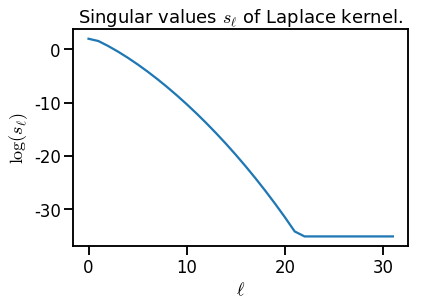

In [4]:
# The area where the singular values asymptote is likely machine precision. 
with sns.plotting_context('talk'):
    plt.figure()
    plt.plot(np.log(svals))
    plt.xlabel('$\ell$')
    plt.ylabel('$\log(s_\ell)$')
    plt.title('Singular values $s_\ell$ of Laplace kernel.')
    plt.show()

In [5]:
# # simulate a spectral function which is known to be sparse in IR
# rhop_supp = np.arange(20, 30)
# rhop_sim = np.zeros((Nomega), dtype = np.float64)
# rhop_sim[rhop_supp] = 1.
# rho_sim = V @ rhop_sim
# G = kernel @ rho_sim

In [6]:
# with sns.plotting_context('talk'):
#     fig, ax = plt.subplots(1, 2, figsize = (15, 5))
#     plot_1d_function(ax[0], omega_line, rhop_sim, title = 'ρ\' in sparse basis', ax_label = ['ω', 'ρ'], \
#                      legend = False, colors = ['c'])
#     plot_1d_function(ax[1], omega_line, rho_sim, title = 'ρ = V ρ\' in regular basis', ax_label = ['ω', 'ρ'], \
#                      legend = False, colors = ['r'])
#     plt.tight_layout()

In [7]:
# Two types of spectral fns to simulate
omega0 = 0.8
delOmega = 0.1
rho = lambda omega : np.exp(- (omega - omega0) ** 2 / (2 * (delOmega ** 2))) / (np.sqrt(2 * np.pi) * delOmega)

# omega_supp = [0.8, 1.1]
# rho = lambda omega : 1 / (omega_supp[1] - omega_supp[0]) if omega > omega_supp[0] and omega < omega_supp[1] else 0

def signal(tau):
    integrand = lambda omega : np.exp(-omega * tau) * rho(omega)
    return quad(integrand, 0, np.inf)[0]
rho_dat = np.array([rho(a) for a in omega_line])
rhop_dat = Vdag @ rho_dat
# check out rhop-- why is it not sparse?

np.random.seed(10)
G = np.array([signal(t) for t in taus])
print('Evaluating Greens function at tau = it = ' + str(taus))

Evaluating Greens function at tau = it = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


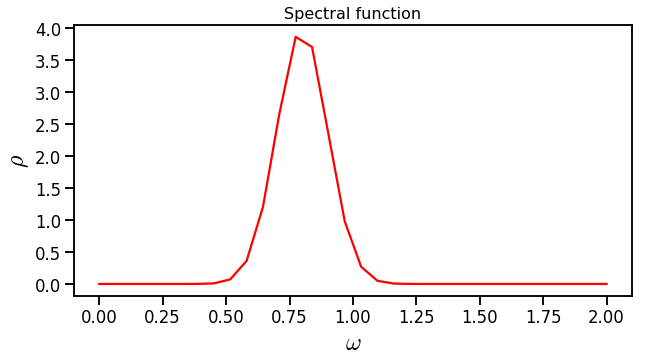

In [8]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    plot_1d_function(ax, omega_line, rho_dat, colors = 'r', title = 'Spectral function', \
                     ax_label = ['$\\omega$', '$\\rho$'], legend = False)

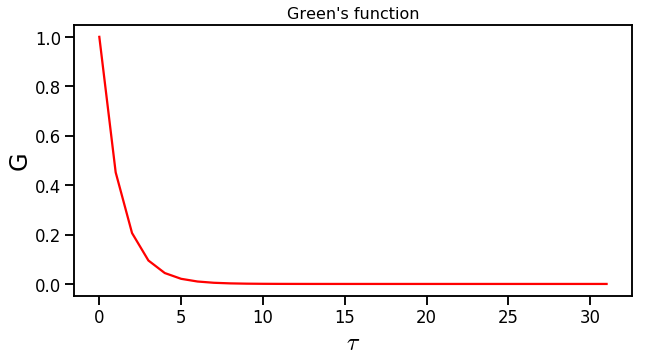

In [9]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    plot_1d_function(ax, taus, G, colors = 'r', title = 'Green\'s function', ax_label = ['$\\tau$', 'G'], \
                     legend = False)

## Solve inverse problem with ADMM

#### ADMM

The Alternating Direction Method of Multipliers (ADMM) is an algorithm which solves the LASSO problem. 

In [10]:
# initialize parameters. Here we'll use the default settings.
params = ADMMParams.default_params(Nomega, d = (Ntau, Nomega))
params.lam = 0.001
params.mu = 0.001
params.mup = 1.
params.max_iters = 100000
params.eps = 1e-5

In [11]:
# TODO try L1 norm for fidelity
rho_recon, xp, resid, iters = admm(G, taus, omegas, params, resid_norm = lpnorm(1))

Starting solver.
Iteration 100: Residual = 1.5824350489449543, elapsed time = 0.01579594612121582
Iteration 200: Residual = 1.5690128300356854, elapsed time = 0.03223609924316406
Iteration 300: Residual = 1.5557635341087028, elapsed time = 0.04840493202209473
Iteration 400: Residual = 1.54268485710822, elapsed time = 0.06432700157165527
Iteration 500: Residual = 1.5297745257525686, elapsed time = 0.08063387870788574
Iteration 600: Residual = 1.5170302971230925, elapsed time = 0.09677481651306152
Iteration 700: Residual = 1.5044499582585358, elapsed time = 0.11268472671508789
Iteration 800: Residual = 1.4920313257548448, elapsed time = 0.12831687927246094
Iteration 900: Residual = 1.4797722453703233, elapsed time = 0.14318585395812988
Iteration 1000: Residual = 1.467670591636054, elapsed time = 0.1556868553161621
Iteration 1100: Residual = 1.4557242674715325, elapsed time = 0.16697192192077637
Iteration 1200: Residual = 1.4446179660679261, elapsed time = 0.17824697494506836
Iteration 13

Iteration 11900: Residual = 0.8847118744555958, elapsed time = 1.631347894668579
Iteration 12000: Residual = 0.8834148740060894, elapsed time = 1.6422200202941895
Iteration 12100: Residual = 0.8821517797472702, elapsed time = 1.6528899669647217
Iteration 12200: Residual = 0.8808943766914101, elapsed time = 1.6635558605194092
Iteration 12300: Residual = 0.8796564821482559, elapsed time = 1.676602840423584
Iteration 12400: Residual = 0.8784327167077988, elapsed time = 1.6891038417816162
Iteration 12500: Residual = 0.8772218145679213, elapsed time = 1.702817678451538
Iteration 12600: Residual = 0.8760242121656566, elapsed time = 1.7161757946014404
Iteration 12700: Residual = 0.8748386361345082, elapsed time = 1.727057933807373
Iteration 12800: Residual = 0.8738675219564064, elapsed time = 1.7376298904418945
Iteration 12900: Residual = 0.8729438963193284, elapsed time = 1.7483320236206055
Iteration 13000: Residual = 0.8720307364183675, elapsed time = 1.7594139575958252
Iteration 13100: Res

Iteration 23700: Residual = 0.7783155986492462, elapsed time = 3.078256845474243
Iteration 23800: Residual = 0.777776970747579, elapsed time = 3.0890860557556152
Iteration 23900: Residual = 0.7772394307232975, elapsed time = 3.099536895751953
Iteration 24000: Residual = 0.7766970809871927, elapsed time = 3.1098239421844482
Iteration 24100: Residual = 0.776160695529011, elapsed time = 3.123914957046509
Iteration 24200: Residual = 0.775622907805402, elapsed time = 3.136528968811035
Iteration 24300: Residual = 0.7750833257511854, elapsed time = 3.1497128009796143
Iteration 24400: Residual = 0.7745483172304902, elapsed time = 3.163059949874878
Iteration 24500: Residual = 0.7740110377397624, elapsed time = 3.1739449501037598
Iteration 24600: Residual = 0.7734740545999461, elapsed time = 3.1849448680877686
Iteration 24700: Residual = 0.7729399887934663, elapsed time = 3.2001700401306152
Iteration 24800: Residual = 0.7724038260062343, elapsed time = 3.2149999141693115
Iteration 24900: Residua

Iteration 35400: Residual = 0.7183203231134978, elapsed time = 4.489078044891357
Iteration 35500: Residual = 0.7178340653046402, elapsed time = 4.499557971954346
Iteration 35600: Residual = 0.7173482390885806, elapsed time = 4.509987831115723
Iteration 35700: Residual = 0.7168628439997986, elapsed time = 4.520776987075806
Iteration 35800: Residual = 0.7163778796352089, elapsed time = 4.532087087631226
Iteration 35900: Residual = 0.7158933455687494, elapsed time = 4.54449987411499
Iteration 36000: Residual = 0.7154092413522395, elapsed time = 4.5577428340911865
Iteration 36100: Residual = 0.7149255665831227, elapsed time = 4.5694358348846436
Iteration 36200: Residual = 0.7144423208276275, elapsed time = 4.58026385307312
Iteration 36300: Residual = 0.7139595036525856, elapsed time = 4.590923070907593
Iteration 36400: Residual = 0.7134771146514745, elapsed time = 4.601738929748535
Iteration 36500: Residual = 0.7129951533895599, elapsed time = 4.613891839981079
Iteration 36600: Residual = 

Iteration 47500: Residual = 0.6180491775389785, elapsed time = 5.9658167362213135
Iteration 47600: Residual = 0.6176036293684077, elapsed time = 5.976764917373657
Iteration 47700: Residual = 0.6173779141625868, elapsed time = 5.987828969955444
Iteration 47800: Residual = 0.6168627157841358, elapsed time = 5.998121976852417
Iteration 47900: Residual = 0.6165958665885134, elapsed time = 6.011741876602173
Iteration 48000: Residual = 0.6162034971059618, elapsed time = 6.025022029876709
Iteration 48100: Residual = 0.6157896601471827, elapsed time = 6.040802717208862
Iteration 48200: Residual = 0.6155154853784716, elapsed time = 6.054152011871338
Iteration 48300: Residual = 0.6150513528454424, elapsed time = 6.065185785293579
Iteration 48400: Residual = 0.6147544406934566, elapsed time = 6.076963901519775
Iteration 48500: Residual = 0.6143691497258661, elapsed time = 6.088830947875977
Iteration 48600: Residual = 0.6139755326698885, elapsed time = 6.099547863006592
Iteration 48700: Residual =

Iteration 57700: Residual = 0.5820546535334264, elapsed time = 7.391079902648926
Iteration 57800: Residual = 0.5817170865514829, elapsed time = 7.403966903686523
Iteration 57900: Residual = 0.5813798708121007, elapsed time = 7.420982122421265
Iteration 58000: Residual = 0.5810428758315287, elapsed time = 7.436197996139526
Iteration 58100: Residual = 0.5807062014920822, elapsed time = 7.452269792556763
Iteration 58200: Residual = 0.5804036858911297, elapsed time = 7.468862056732178
Iteration 58300: Residual = 0.5801052423857105, elapsed time = 7.485118865966797
Iteration 58400: Residual = 0.5798070326972273, elapsed time = 7.501378774642944
Iteration 58500: Residual = 0.5795090736794932, elapsed time = 7.517207860946655
Iteration 58600: Residual = 0.579211344561912, elapsed time = 7.532578706741333
Iteration 58700: Residual = 0.5789138614545657, elapsed time = 7.549036026000977
Iteration 58800: Residual = 0.5786166171197988, elapsed time = 7.5652899742126465
Iteration 58900: Residual = 

Iteration 68000: Residual = 0.5522668610700902, elapsed time = 8.815441846847534
Iteration 68100: Residual = 0.5519909874871312, elapsed time = 8.826580047607422
Iteration 68200: Residual = 0.5517153342288881, elapsed time = 8.837432861328125
Iteration 68300: Residual = 0.5514399010931836, elapsed time = 8.848334789276123
Iteration 68400: Residual = 0.5511646878871249, elapsed time = 8.862331867218018
Iteration 68500: Residual = 0.5508896944157153, elapsed time = 8.874895811080933
Iteration 68600: Residual = 0.5506149204799307, elapsed time = 8.890974998474121
Iteration 68700: Residual = 0.5503403658890434, elapsed time = 8.906652927398682
Iteration 68800: Residual = 0.5500660304438133, elapsed time = 8.919289827346802
Iteration 68900: Residual = 0.5497919139515244, elapsed time = 8.931196928024292
Iteration 69000: Residual = 0.5495180162174333, elapsed time = 8.942757844924927
Iteration 69100: Residual = 0.5492443370447923, elapsed time = 8.955767154693604
Iteration 69200: Residual = 

Iteration 78900: Residual = 0.5243993785792342, elapsed time = 10.235565900802612
Iteration 79000: Residual = 0.5230949233710749, elapsed time = 10.249456882476807
Iteration 79100: Residual = 0.5259406677049283, elapsed time = 10.261642932891846
Iteration 79200: Residual = 0.5219255279666535, elapsed time = 10.273711919784546
Iteration 79300: Residual = 0.5253051048383036, elapsed time = 10.285634756088257
Iteration 79400: Residual = 0.5223211724056076, elapsed time = 10.298044919967651
Iteration 79500: Residual = 0.5238830837093154, elapsed time = 10.31244707107544
Iteration 79600: Residual = 0.5227739748306636, elapsed time = 10.328742980957031
Iteration 79700: Residual = 0.5229188448013085, elapsed time = 10.3451509475708
Iteration 79800: Residual = 0.5225588158441752, elapsed time = 10.361004114151001
Iteration 79900: Residual = 0.5224292831558839, elapsed time = 10.377471923828125
Iteration 80000: Residual = 0.5222343451957233, elapsed time = 10.393627882003784
Iteration 80100: Re

Iteration 90100: Residual = 0.5008362951353568, elapsed time = 11.891051054000854
Iteration 90200: Residual = 0.5006383728981599, elapsed time = 11.907382011413574
Iteration 90300: Residual = 0.5004340792787523, elapsed time = 11.922879934310913
Iteration 90400: Residual = 0.5002363773423522, elapsed time = 11.936833143234253
Iteration 90500: Residual = 0.5000333933768709, elapsed time = 11.951836824417114
Iteration 90600: Residual = 0.499834674109622, elapsed time = 11.967978954315186
Iteration 90700: Residual = 0.499633624133407, elapsed time = 11.98361086845398
Iteration 90800: Residual = 0.49943381654920826, elapsed time = 11.995769739151001
Iteration 90900: Residual = 0.49923440085247045, elapsed time = 12.00651502609253
Iteration 91000: Residual = 0.49903395732467, elapsed time = 12.0176100730896
Iteration 91100: Residual = 0.49883571792616604, elapsed time = 12.028341054916382
Iteration 91200: Residual = 0.4986350504116744, elapsed time = 12.040369987487793
Iteration 91300: Resi

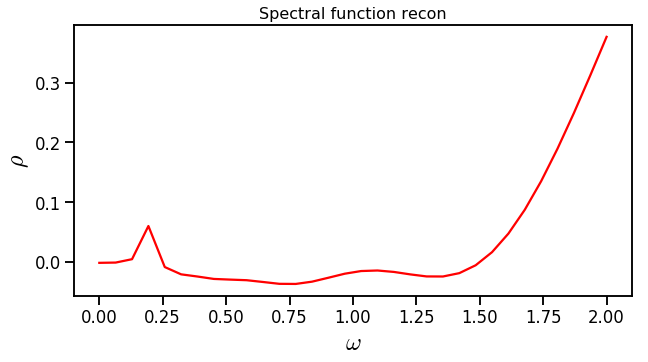

In [12]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    plot_1d_function(ax, omegas, rho_recon, colors = 'r', title = 'Spectral function recon', \
                     ax_label = ['$\\omega$', '$\\rho$'], legend = False)

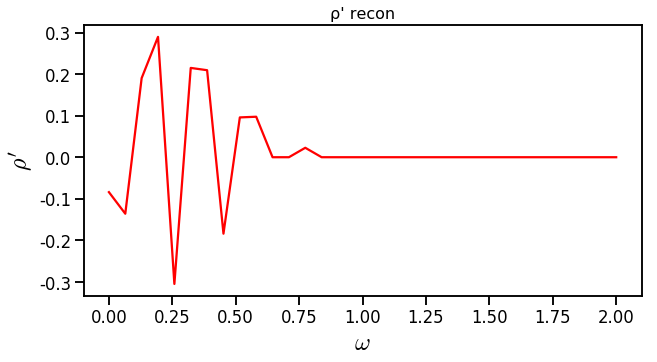

In [13]:
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(1, figsize = (10, 5))
    plot_1d_function(ax, omegas, xp, colors = 'r', title = 'ρ\' recon', \
                     ax_label = ['$\\omega$', '$\\rho\'$'], legend = False)

In [14]:
G - kernel @ rho_recon

array([-5.55111512e-16,  4.02154764e-01,  2.41939594e-01,  1.16859914e-01,
        5.13515838e-02,  1.99042803e-02,  5.35963726e-03, -1.05447616e-03,
       -3.58478267e-03, -4.27625361e-03, -4.12084128e-03, -3.60328465e-03,
       -2.96054137e-03, -2.30671979e-03, -1.69428323e-03, -1.14458147e-03,
       -6.63346305e-04, -2.48672450e-04,  1.04831172e-04,  4.03878427e-04,
        6.55392663e-04,  8.65954738e-04,  1.04155329e-03,  1.18749729e-03,
        1.30841413e-03,  1.40829067e-03,  1.49053376e-03,  1.55803696e-03,
        1.61324662e-03,  1.65822365e-03,  1.69469936e-03,  1.72412484e-03])

Have to figure out-- why isn't $\rho'$ sparse?